# Machine Learning - Regressions

-- [SICSS Zürich 2021](https://github.com/computational-social-science-zurich/sicss-zurich) -- 


Regression belongs like classification to the field of **supervised learning**. 


<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
<strong>Regression predicts numerical values</strong> 
in contrast to classification which predicts categories.
</div>

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
    Other differences are:
<ul>
    <li> Accuracy in measured differently </li>
    <li> Other algorithms </li>
   </ul>

</div>

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

## General ML Procedure

0. Look at the data
1. Select a ML method (eg. LASSO)
2. Draw randomly a hold-out sample from the data
3. Estimate the ML model using different hyperparameters
4. Select the optimal hyperparameters
5. Predict $\hat Y$ using hyperparameters and extrapolated the fitted values to the retarded hold-out-sample
6. Evaluation the prediction power of the ML in the hold-out-sample

## Scikit-Learn Design Overview
### Estimator: an object that can estimate parameters
- e.g. `linear_models.LinearRegression`
- Estimation performed by `fit()` method
- Exogenous parameters (provided by the researcher) are called `hyperparameters`

### Transformer (preprocessor): An object that transforms a data set.
- e.g. `preprocessing.StandardScaler`
- Transformation is performed by the `transform()` method.
- The convenience method `fit_transform()` both fits an estimator and returns the transformed input data set.

### Predictor: An object that forms a prediction from an input data set.
- e.g. `LinearRegression`, after training
- The `predict()` method forms the predictions.
- It also has a `score()` method that measures the quality of the predictions given a test set.

### Miscellaneous
- **Inspection**: Hyperparameters and parameters are accessible. Learned parameters have an underscore suffix (e.g.`lin_reg.coef_`)
- **Non-proliferation of classes**: Use native Python data types; existing building blocks are used as much as possible.
- **Sensible defaults**: Provides reasonable default values for hyperparameters – easy to get a good baseline up and running

## Set up and load data

## Boston housing data

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn

We use as an example the **Boston housing data** (from `sklearn`), which contains 13 attributes of housing markets around Boston. The data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

The objective is to **predict the value of prices** of the house using the given features

In [3]:
from sklearn.datasets import load_boston
data = load_boston() # object is a dictionary
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Data Set Characteristics:

In [4]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Create $X$ and $y$

In [5]:
X_full, y_full = data.data, data.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [6]:
X_df=pd.DataFrame(X_full, columns=data['feature_names']) # to dataframe format
X_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Look for null values in the dataset

In [7]:
X_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

There is none

## Exploratory Data Analysis

### Quantity to predict= price (`target` or $y$) 

Before the regression, let us inspect the features and their distributions. 

In [8]:
y_full.shape

(506,)

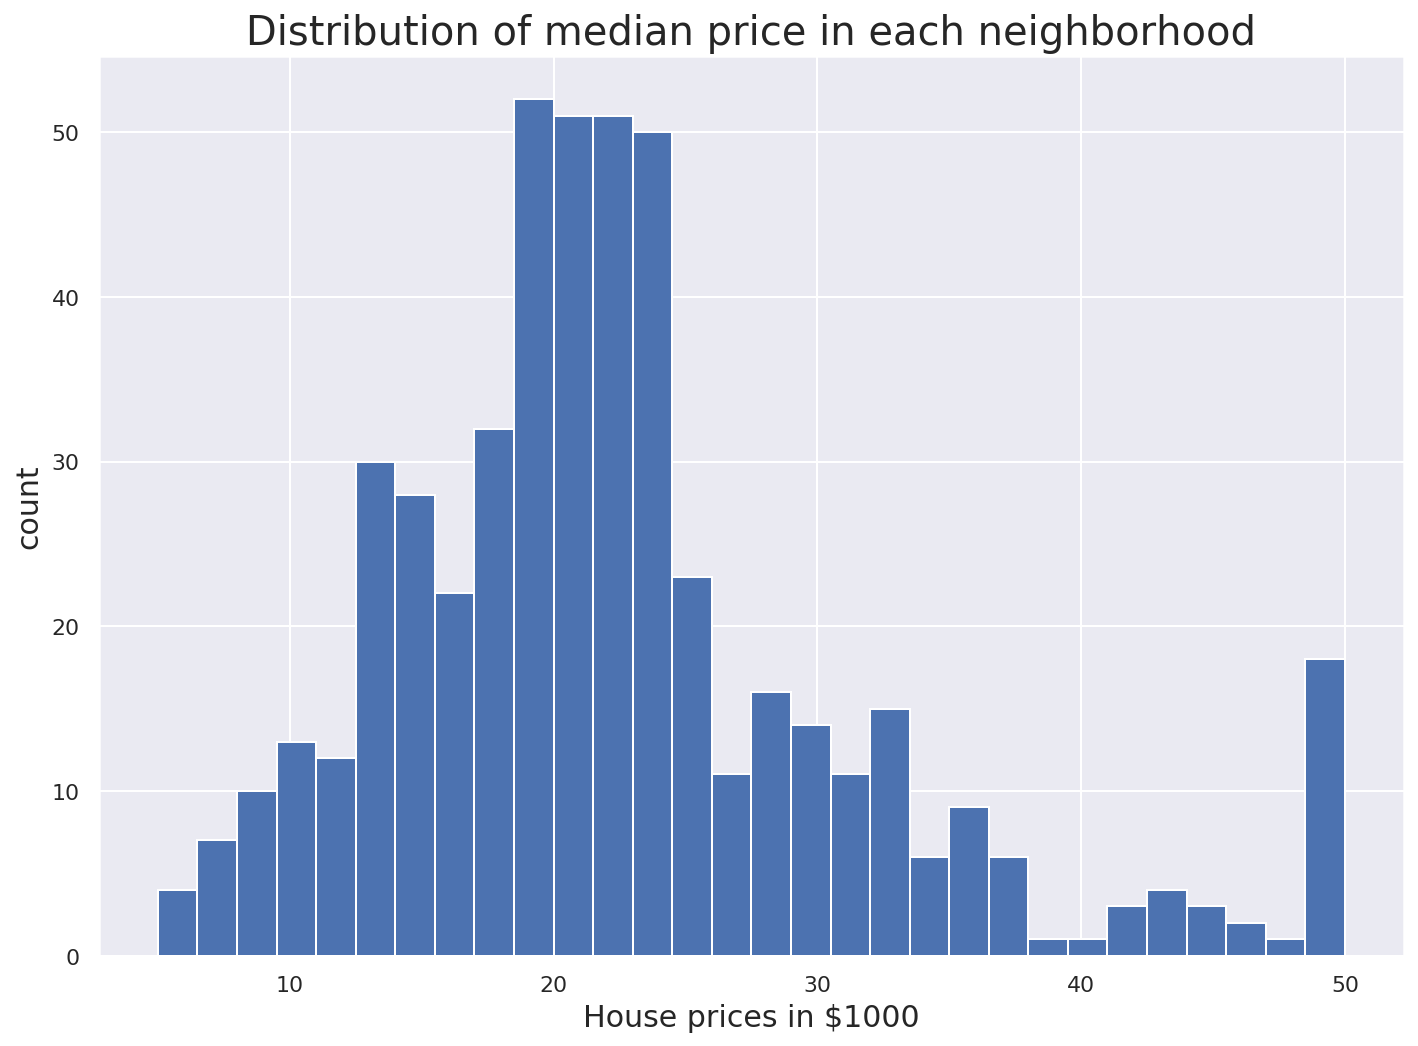

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(y_full, bins=30)
plt.xlabel("House prices in $1000", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of median price in each neighborhood', size=20)
plt.show()

### Features ($X$) used for prediction

In [10]:
X_full.shape

(506, 13)

#### Distributions
**Histogram plots** to look at the distribution

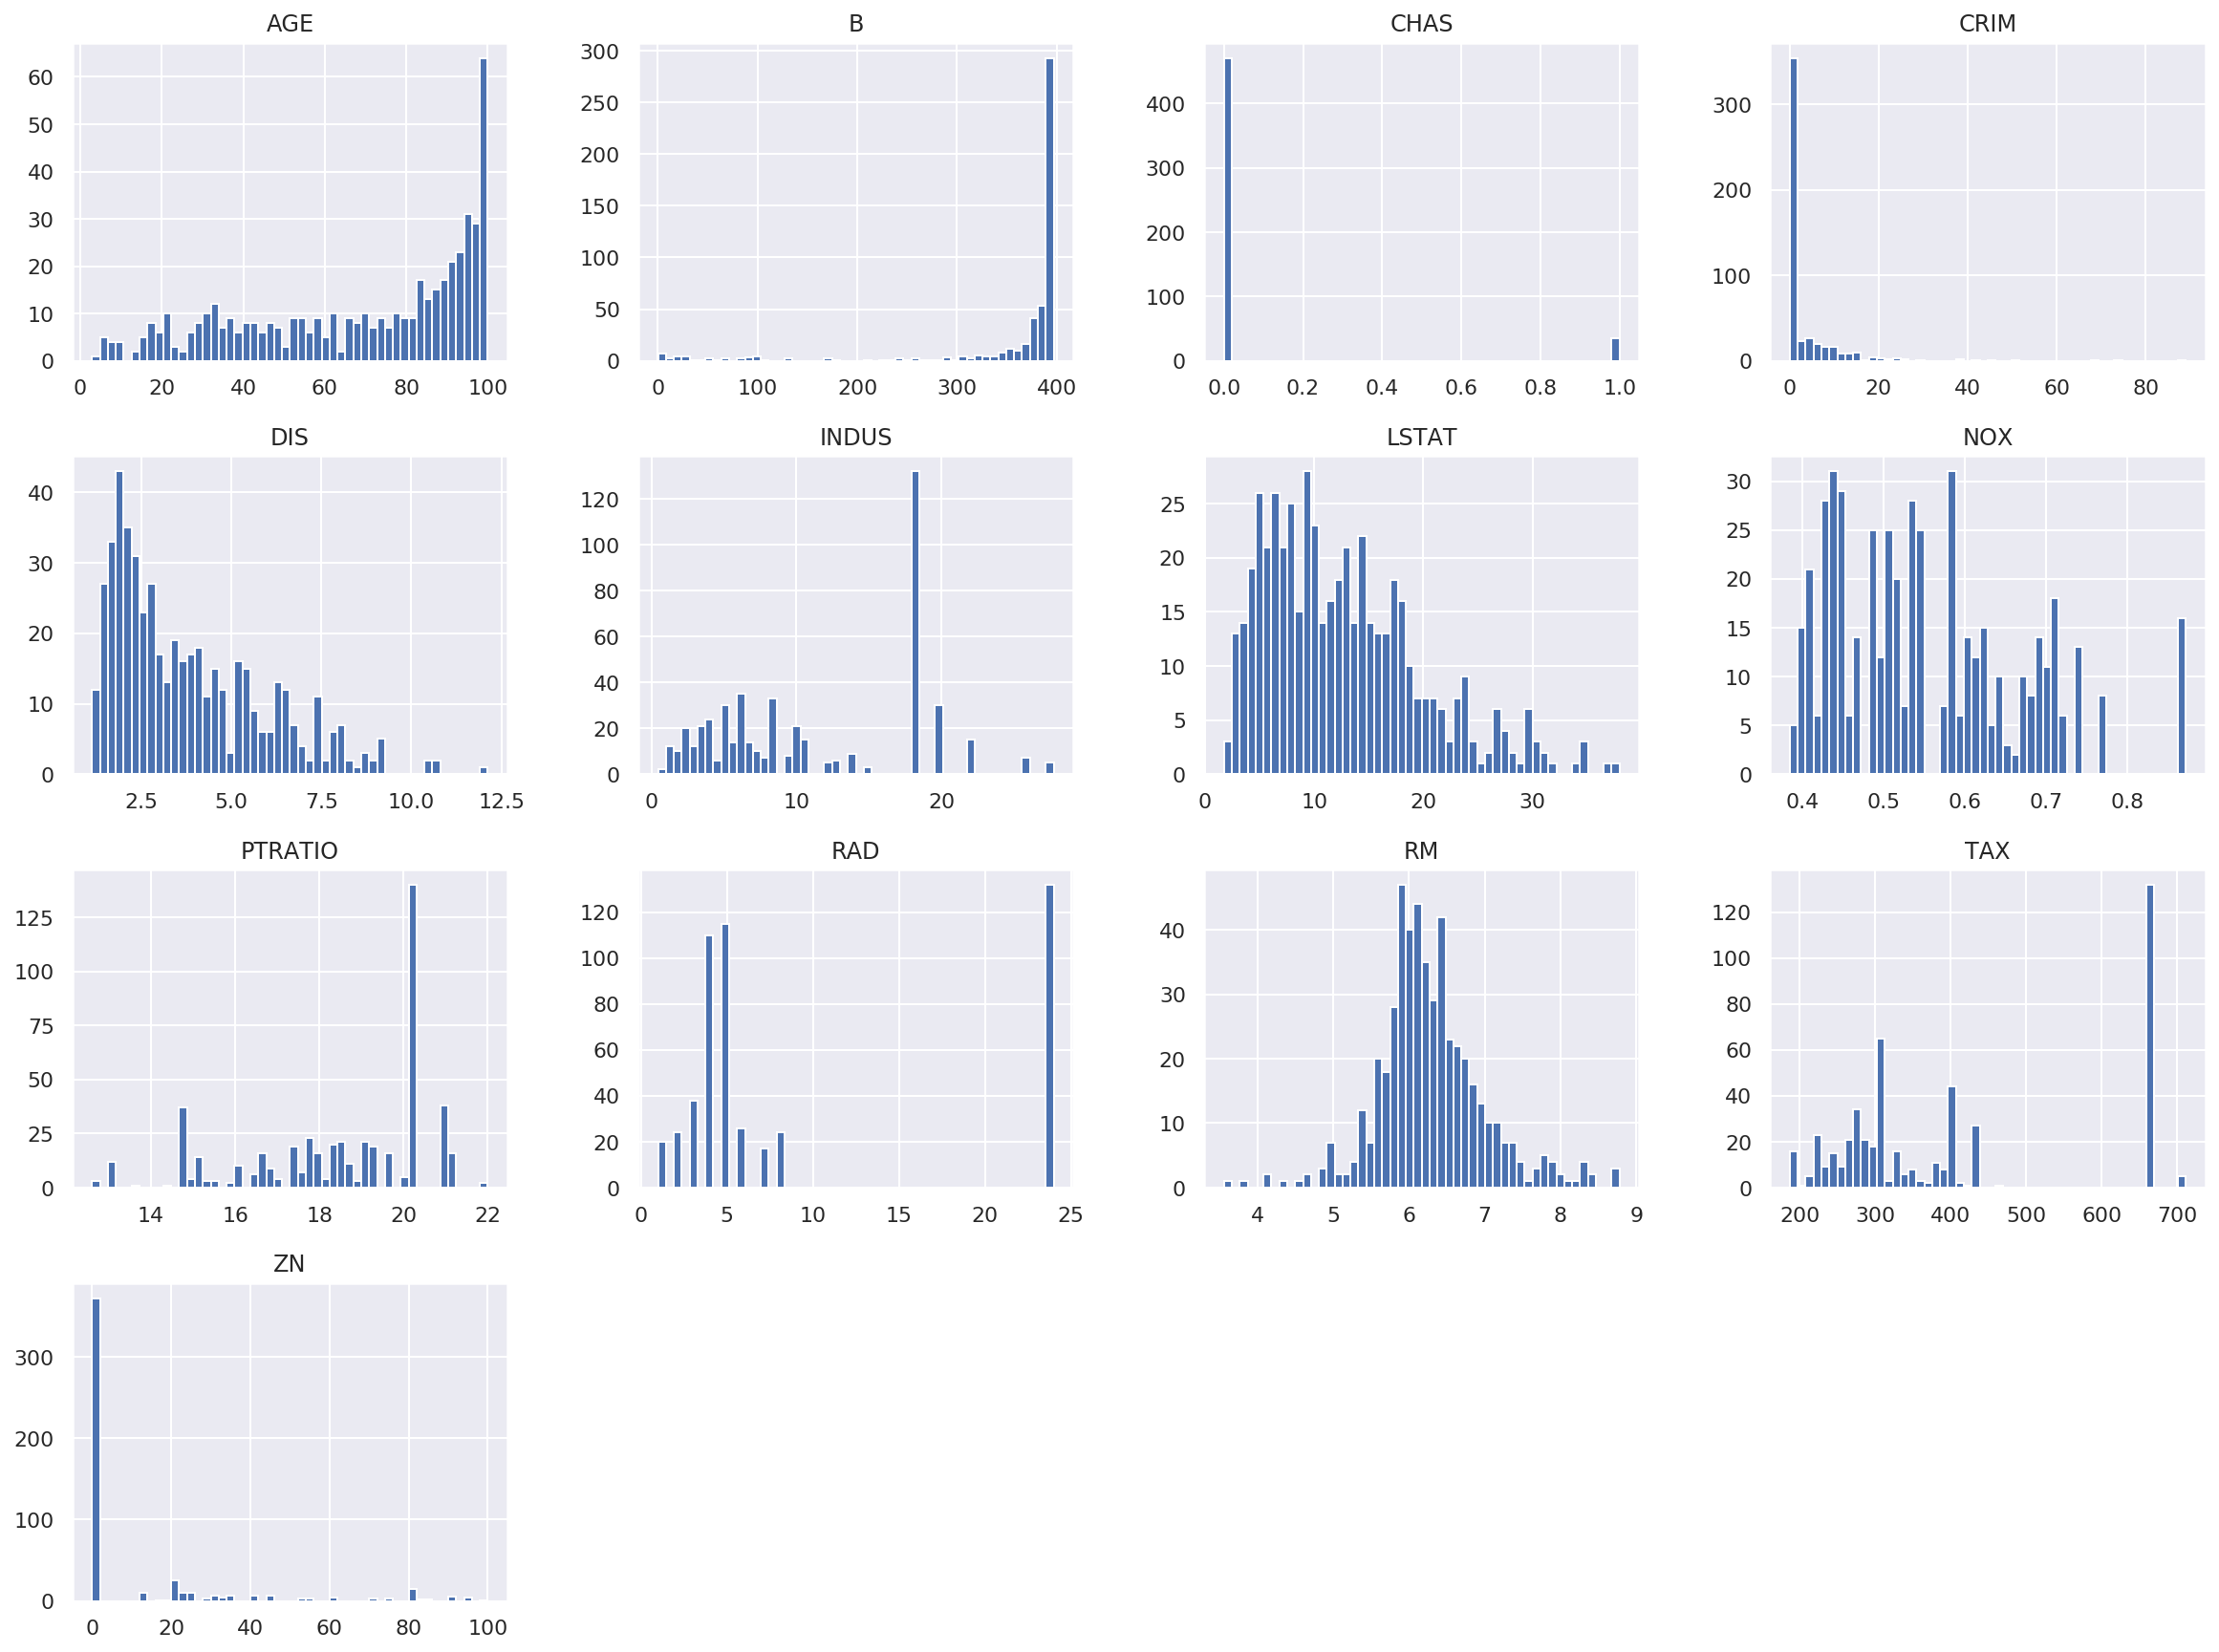

In [11]:
X_df.hist(bins=50, figsize=(20,15))
plt.show()

### Correlations

**Boston Correlation Heatmap Example with Seaborn**

The seaborn package offers a heatmap that will allow a two-dimensional graphical representation of the Boston data. The heatmap will represent the individual values that are contained in a matrix are represented as colors.

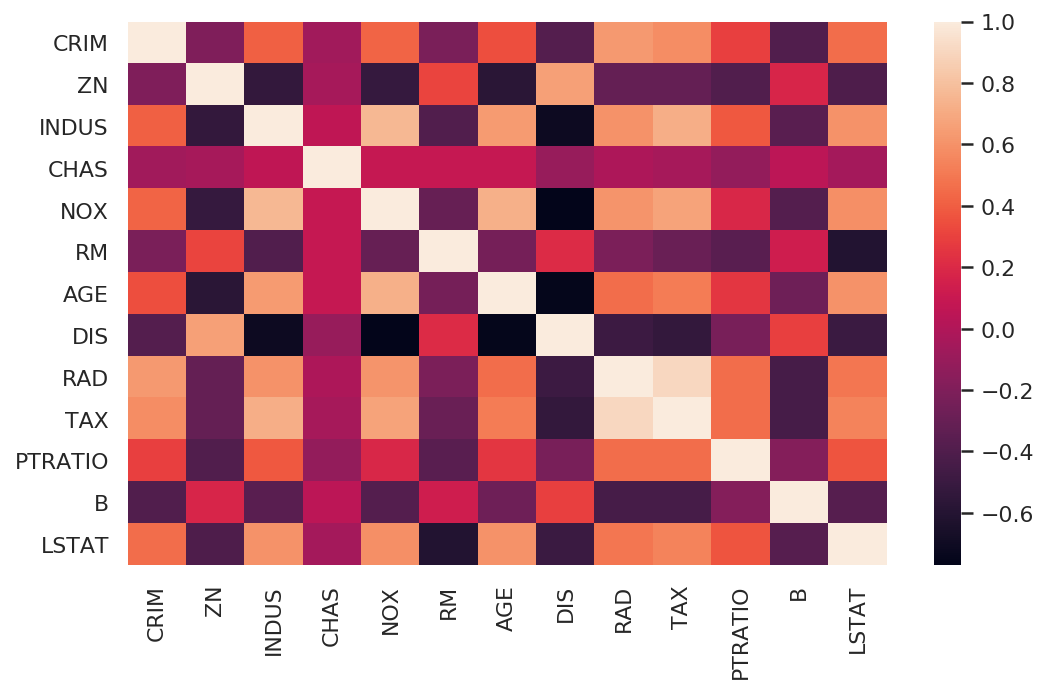

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.5,5)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

### Check for multicolinearity

An important point in selecting features for a linear regression model is to check for **multicolinearity**. 

The features RAD, TAX have a correlation of 0.91. These feature pairs are strongly correlated to each other. This can affect the model. 

Same goes for the features DIS and AGE which have a correlation of -0.75.

### Correlation plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f09a754e0>,
      dtype=object)

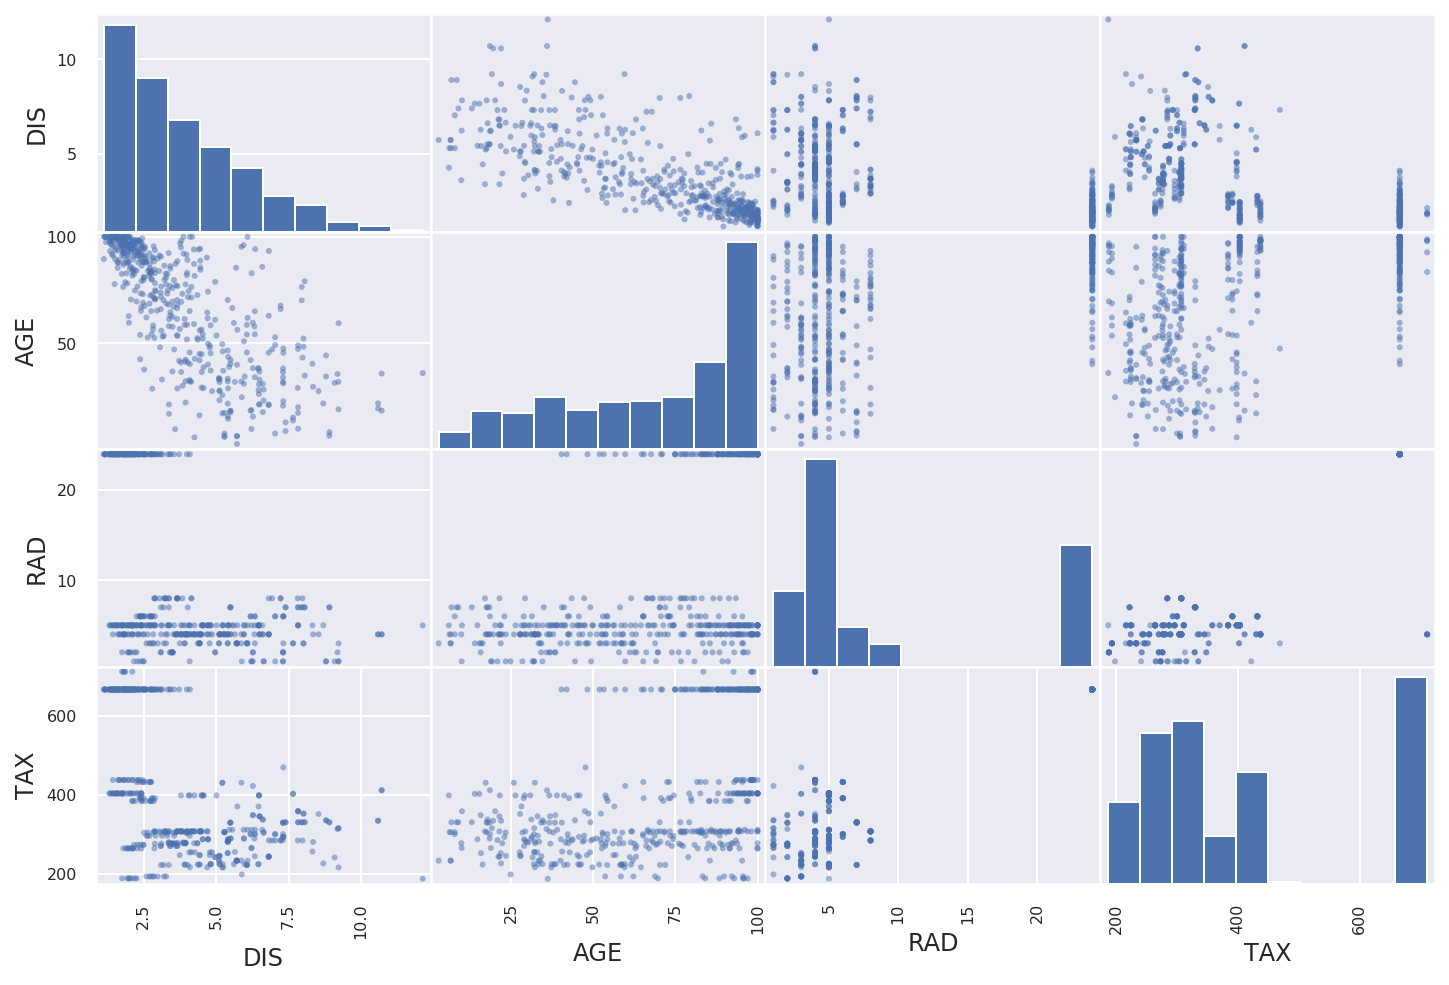

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_df[['DIS', 'AGE','RAD', 'TAX']], figsize=(12, 8))

### Scatter plot relative to the target (price)

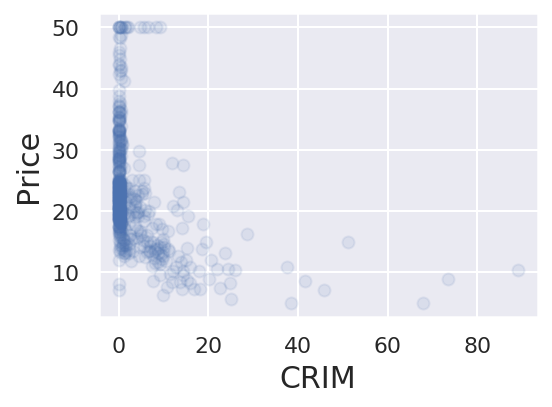

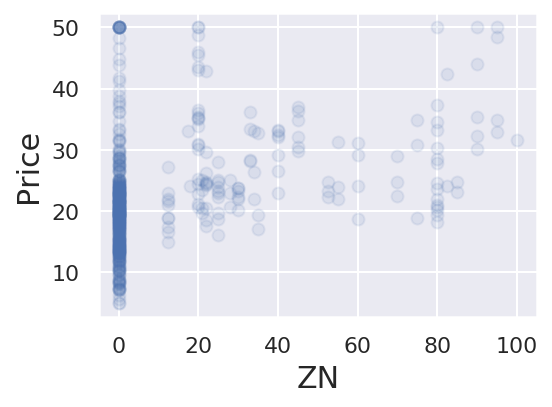

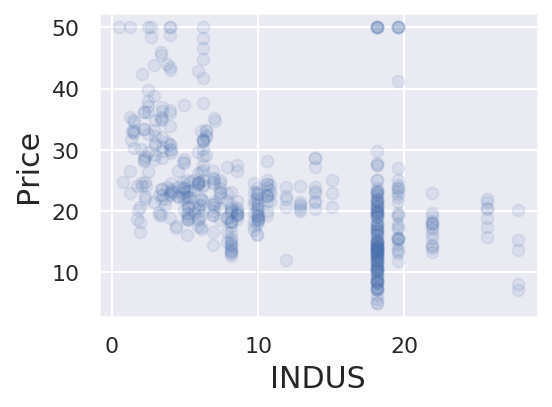

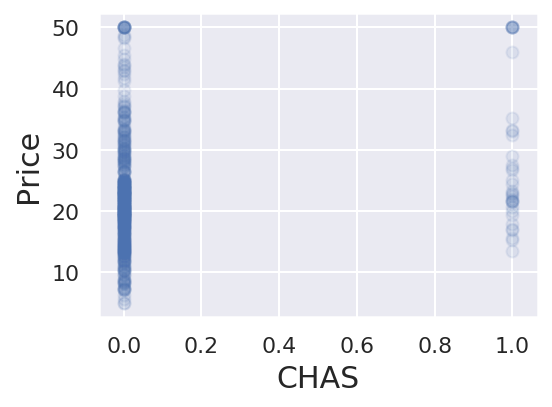

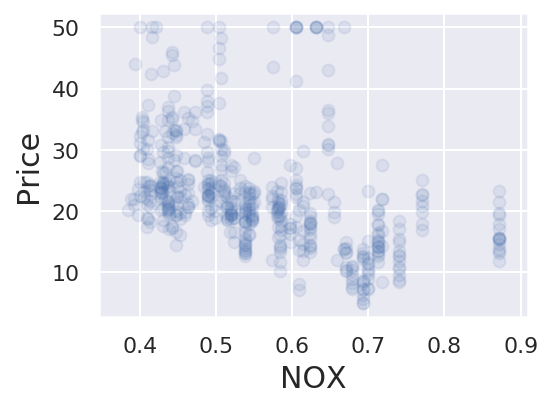

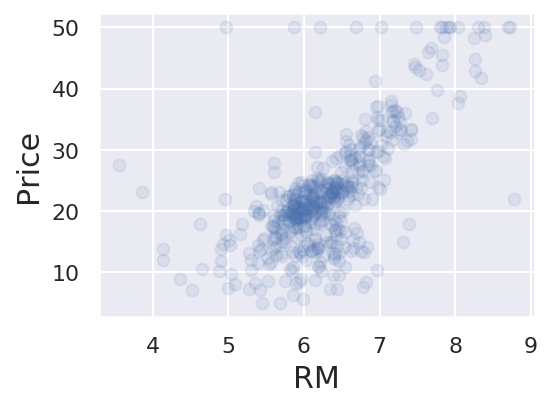

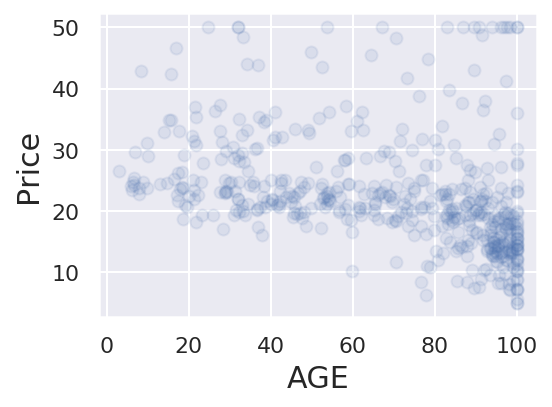

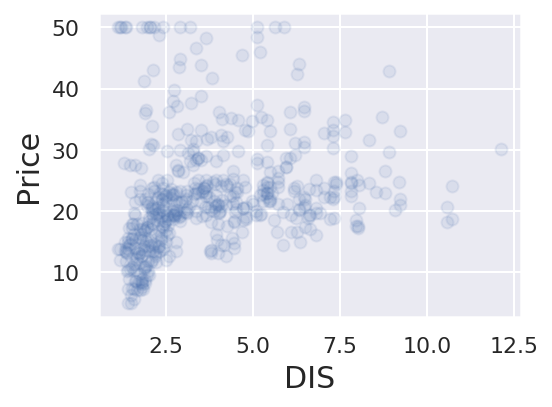

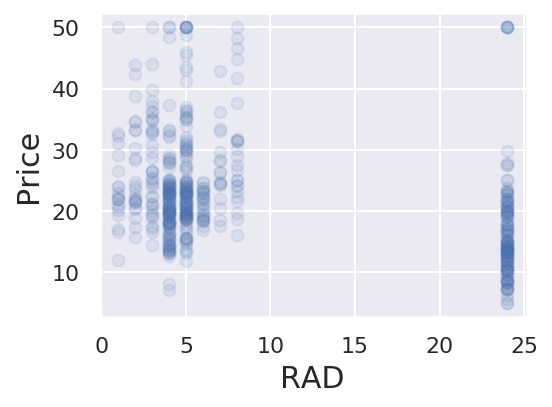

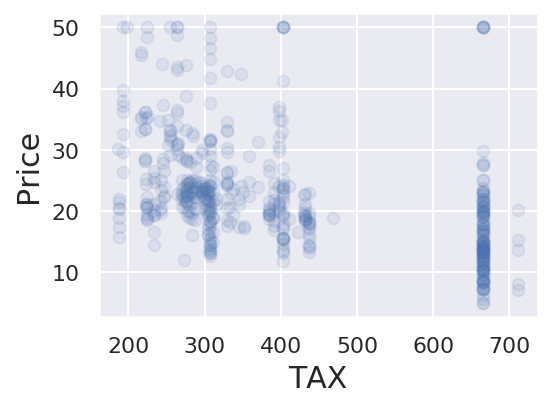

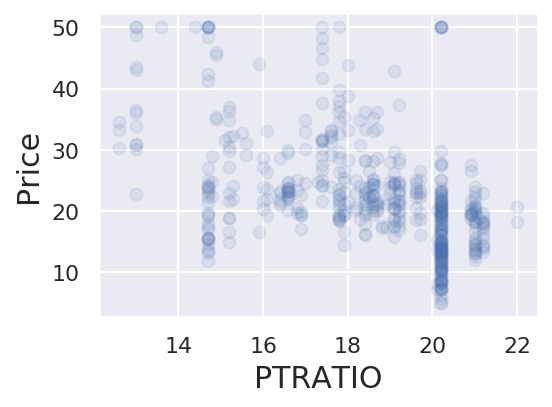

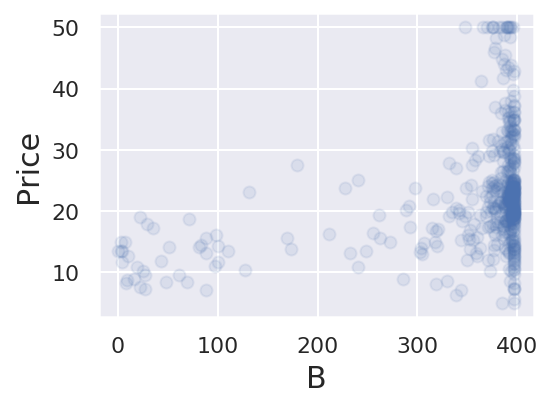

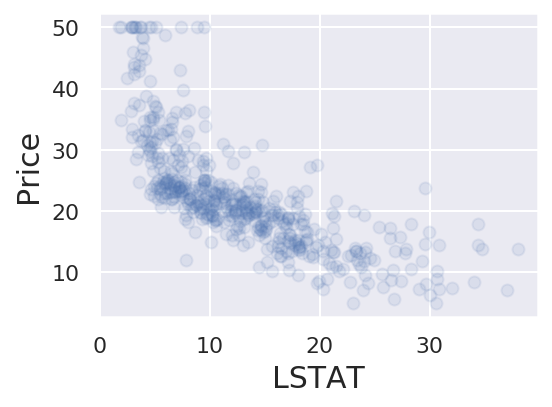

In [14]:
for feature_name in X_df.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(X_df[feature_name], y_full, alpha=0.1)
    plt.ylabel('Price', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

### What can we say ? 

- The prices increase as the value of RM increases linearly. There are few outliers and the data seems to be capped at 50.

- The prices tend to decrease with an increase in LSTAT. Though it doesn’t look to be following exactly a linear line.

## Prepare the data for ML algorithms

### Drop some labeled observations:

Drop the observations with price >=50 (because of the right censure)

In [15]:
mask=y_full<50

y_full=y_full[mask==True]
X_full=X_full[mask==True]
X_df=X_df[mask==True]

## Split train test sets 
### Using `train_test_split`
Pure ramdomness of the sampling method

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=0.2, random_state=1)
print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

train data (392, 13) (392,)
test data (98, 13) (98,)


### Data cleaning
The missing features should be:
1. dropped
2. imputed to some value (zero, the mean, the median...)

### Feature Scaling
Most common scaling methods: 
- **standardization**= normalization by substracting the mean and dividing by the standard deviation (values are not bounded)
- **Min-max scaling**= normalization by substracting the minimum and dividing by the maximum (values between `0` and `1`)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Select and Train a Model
**Regression algorithm** (we consider firs the `LinearRegression`, more algorithms will be discussed later):
### First algorithm: Simple Linear Regression

In [18]:
# our first machine learning model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;<strong><code>scikit-learn</code> API</strong>

In <code>scikit-learn</code> all regression algorithms have:
<ul>
    <li>a <strong><code>fit()</code></strong> method to learn from data, and</li>
    <li>and a subsequent <strong><code>predict()</code></strong> method for predicting numbers from input features.</li>
</ul>
</div>

In [19]:
lin_reg.fit(X_train, y_train)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train, y_train), 2)))

R-squared for training dataset:0.79


In [20]:
lin_reg.fit(X_train_scaled, y_train)
print("R-squared for training dataset & scaled features:{}".
      format(np.round(lin_reg.score(X_train_scaled, y_train), 2)))

R-squared for training dataset & scaled features:0.79


### Coefficients of the linear regression

In [21]:
features = list(X_df.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'CRIM': -0.82, 'ZN': 0.96, 'INDUS': -0.54, 'CHAS': 0.19, 'NOX': -1.5, 'RM': 2.16, 'AGE': -0.55, 'DIS': -2.79, 'RAD': 2.17, 'TAX': -2.22, 'PTRATIO': -1.86, 'B': 0.72, 'LSTAT': -2.7}


## Metrics / error measures   

`scikit-learn` offers the following metrics for measuring regression quality:

### Mean absolute error

Taking absolute values before adding up the deviatons assures that deviations with different signs can not cancel out.

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean absolute error</strong> is defined as 


$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


</div>


`neg_mean_absolute_error` in `scikit-learn`.

### Mean squared error

Here we replace the absolute difference by its squared difference. Squaring also insures positive differeces.


<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean squared error</strong> is defined as 



$$
\frac{1}{n} \left(\, (y_1 - \hat{y}_1)^2 \, + \, (y_2 - \hat{y}_2)^2 \, \, \ldots \,+ \,(y_n - \hat{y}_n)^2 \,\right)
$$


</div>



This measure is more sensitive to **outliers**: A few larger differences contribute more significantly to a larger mean squared error. 

`neg_mean_squared_error` in `scikit-learn`.

### Median absolute error

Here we replace mean calculation by median. 

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>median absolute error</strong> is defined as 



$$
\text{median}\left(\,|y_1 - \hat{y}_1|, \,|y_2 - \hat{y}_2|, \,\ldots, \,|y_n - \hat{y}_n| \, \right)
$$


</div>


This measure is less sensitive to outliers: A few larger differences will not contribute significantly to a larger error value. 

`neg_median_absolute_error` in `scikit-learn`.

### Mean squared log error

The formula for this metric can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). 

This metric is recommended **when your target values are distributed over a huge range of values**, like popoluation numbers. 

The previous error metrics would put a larger weight on large target values. 

The name is `neg_mean_squared_log_error`

### In-sample performance with MSE

In [22]:
from sklearn.metrics import mean_squared_error

y_train_pred = lin_reg.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print("RMSE: %s" % train_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2)) 

RMSE: 3.6792311563556526


<div class="alert alert-info">
<h3> Your turn</h3>
    Compute:
    <ul>
        <li>the out-of-sample mean squarred error
        </li>
        <li> mean  absolute error (using $mean\ absolute\ error$ from $sklearn.metrics$: you need to import the function)
        </li>
    </ul>
</div>

In [23]:
#1. Out-of-sample performance
y_test_pred = lin_reg.predict(X_test_scaled)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("RMS: %s" % test_rmse) 

RMS: 3.8824350594341417


In [24]:
# 2. mean  absolute error
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, y_test_pred)
lin_rmae = np.sqrt(lin_mae)
print("RMAE: %s" % lin_rmae) 

RMAE: 1.6979249376874554


### Explained variance and $R^2$-score

Two other scores to mention are *explained variance* and $R^2$-score. For both larger values indicate better regression results.

The $R^2$-score corresponds to **the proportion of variance (of $y$) that has been explained by the independent variables in the model**. 
It takes values in the range $0 .. 1$. The name within `scikit-learn` is `R2`. 

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>$R^2$</strong> is defined as 

$$
R^2= 1-\frac{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

</div>

The formula for [explained variance](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score), the score takes values up to $1$. The name within `scikit-learn` is `explained_variance`.

In [25]:
from sklearn.metrics import r2_score
r2=round(r2_score(y_test, y_test_pred), 2)
print("R2: %s" % r2) 

R2: 0.73


### Binned Regression Plots

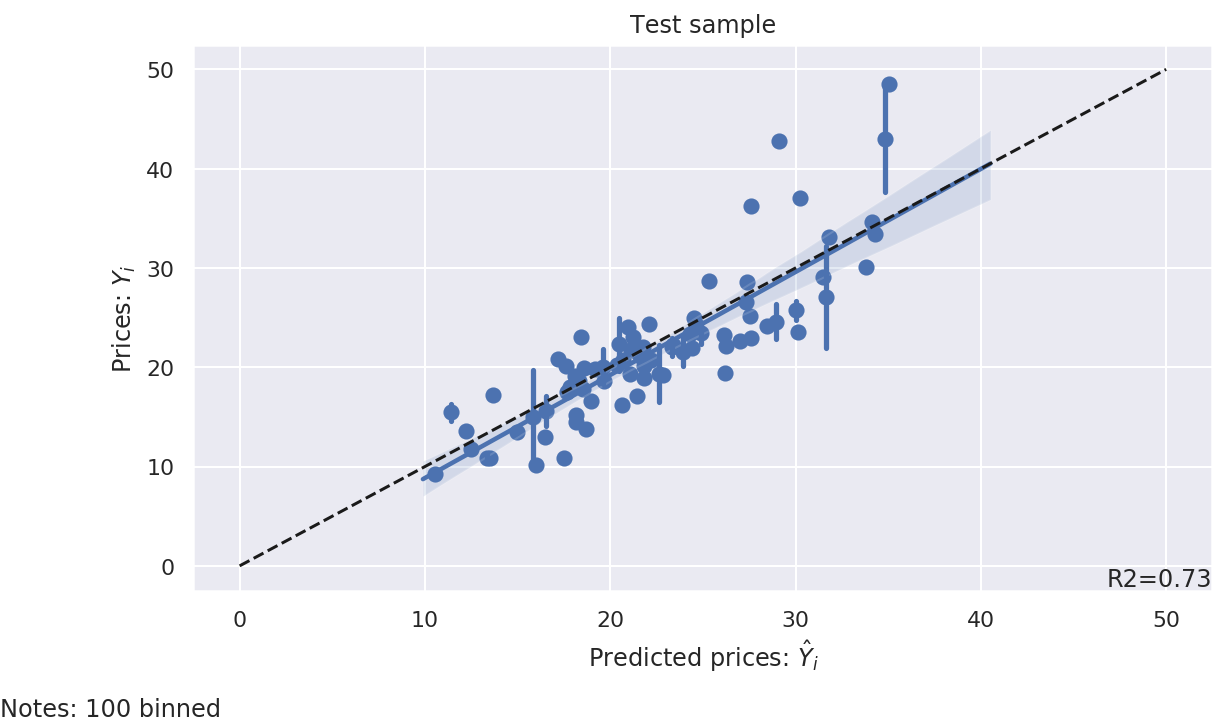

In [26]:
# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins=100)
g=g.set_title("Test sample")

plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

### Plotting Regression Residuals

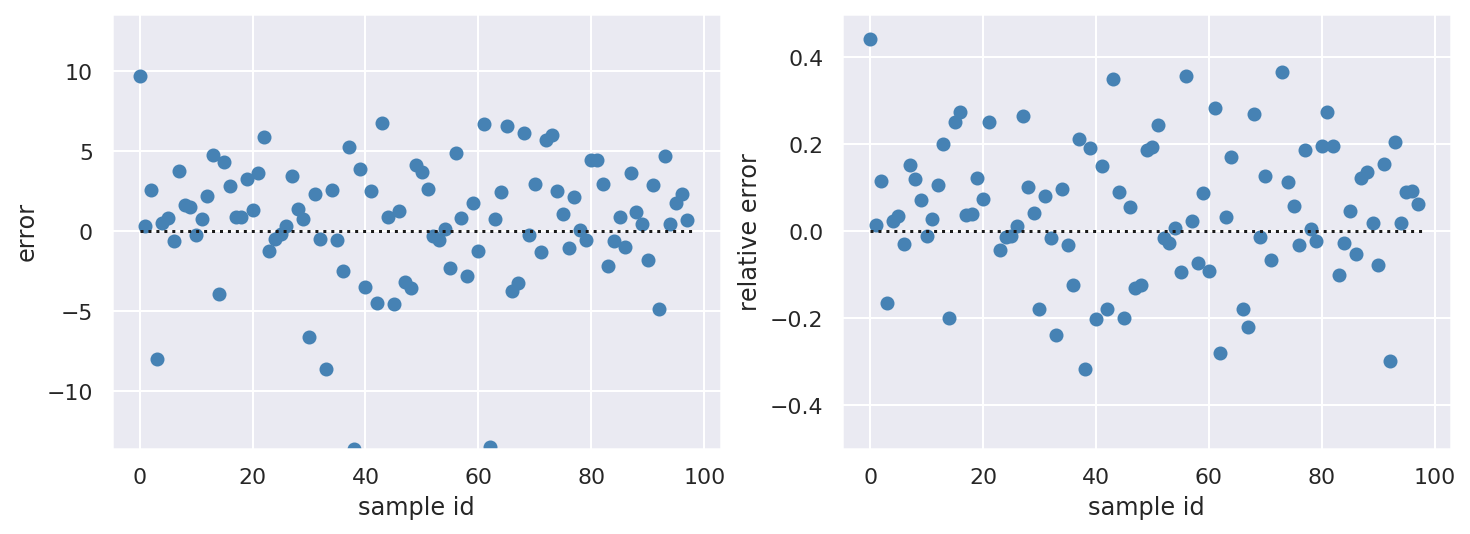

In [27]:
#Let us plot how good given and predicted values match on the training data set (sic !).
def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

plot_fit_quality(y_test, y_test_pred)

<div class="alert alert-info">
<h3> Your turn</h3>
    Train a ridge model and look at the goodeness of fit
</div>

In [28]:
from sklearn.linear_model import Ridge

In [29]:
ridge_reg=Ridge(alpha=2)       
ridge_reg.fit(X_train, y_train) 

y_train_pred=ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

train RMS: 3.6792311563556526
test RMS: 3.8991529766060626
train R2: 0.78
test R2: 0.73


In [30]:
print('The coefficients of the features from the Ridge model:')
print(dict(zip(features, [round(x, 2) for x in ridge_reg.coef_])))

The coefficients of the features from the Ridge model:
{'CRIM': -0.09, 'ZN': 0.04, 'INDUS': -0.12, 'CHAS': 0.63, 'NOX': -4.79, 'RM': 3.34, 'AGE': -0.03, 'DIS': -1.21, 'RAD': 0.23, 'TAX': -0.01, 'PTRATIO': -0.8, 'B': 0.01, 'LSTAT': -0.38}


#### Polynomial regression

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly_features=PolynomialFeatures(degree=2)
X_train_poly=poly_features.fit_transform(X_train)
X_test_poly=poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

y_test_pred = lin_reg.predict(X_test_poly)
test_rmse = mean_squared_error(y_test,y_test_pred)
test_rmse = np.sqrt(test_rmse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

test RMS: 3.7051965810729564
train R2: 0.78
test R2: 0.76


### Lasso regression

In [32]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1)       
lasso_reg.fit(X_train, y_train)

y_test_pred = lasso_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 4.579918320353294
train R2: 0.78
test R2: 0.63


### Lasso regression -- with scaled X

In [33]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1)       
lasso_reg.fit(X_train_scaled, y_train)

y_test_pred = lasso_reg.predict(X_test_scaled)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 4.342235733030307
train R2: 0.78
test R2: 0.66


In [34]:
print('The coefficients of the features from the Lasso model:')
print(dict(zip(features, [round(x, 2) for x in lasso_reg.coef_])))

The coefficients of the features from the Lasso model:
{'CRIM': -0.0, 'ZN': 0.0, 'INDUS': -0.23, 'CHAS': 0.0, 'NOX': -0.0, 'RM': 2.02, 'AGE': -0.0, 'DIS': 0.0, 'RAD': -0.0, 'TAX': -0.64, 'PTRATIO': -1.17, 'B': 0.06, 'LSTAT': -2.88}


#### Elastic Net

In [35]:
from sklearn.linear_model import ElasticNet
elanet_reg=ElasticNet(random_state=0)
elanet_reg.fit(X_train_scaled, y_train)

y_test_pred = elanet_reg.predict(X_test_scaled)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 4.363821963597824
train R2: 0.78
test R2: 0.66


In [36]:
print('The coefficients of the features from the Lasso model:')
print(dict(zip(features, [round(x, 2) for x in elanet_reg.coef_])))

The coefficients of the features from the Lasso model:
{'CRIM': -0.36, 'ZN': 0.07, 'INDUS': -0.62, 'CHAS': 0.0, 'NOX': -0.27, 'RM': 1.82, 'AGE': -0.19, 'DIS': -0.0, 'RAD': -0.0, 'TAX': -0.6, 'PTRATIO': -1.15, 'B': 0.36, 'LSTAT': -1.78}


## Setting the **regularization parameter**: generalized Cross-Validation.

In [37]:
alphas=np.logspace(-6, 6, 13)

In [38]:
from sklearn import linear_model
lassocv_reg = linear_model.LassoCV(alphas=alphas)
lassocv_reg.fit(X_train, y_train)
alpha=lassocv_reg.alpha_ 
print("Best alpha", alpha)

Best alpha 0.001


### Then re-run the model using the best $\alpha$

In [39]:
lasso_reg=Lasso(alpha=alpha)       

lasso_reg.fit(X_train_scaled, y_train)

y_train_pred=lasso_reg.predict(X_train_scaled)
y_test_pred = lasso_reg.predict(X_test_scaled)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 3.881814011244504
train R2: 0.79
test R2: 0.73


## Fine-tuning of the Model

### Model Evaluation using Cross-Validation

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; cross_val_score expect a utility function rather than a cost function: the scoring function is the opposite of the MSE. 
</div>


In [40]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Perform 6-fold cross validation
scores = cross_val_score(elanet_reg, X_train_scaled, y_train, 
                         scoring="neg_mean_squared_error", cv=5)
scores

array([-14.96383737, -20.02416214, -20.20072418, -22.69197907,
       -19.66651518])

### Make cross validated predictions

In [41]:
y_train_pred_cv = cross_val_predict(elanet_reg, X_train_scaled, y_train, cv=5)

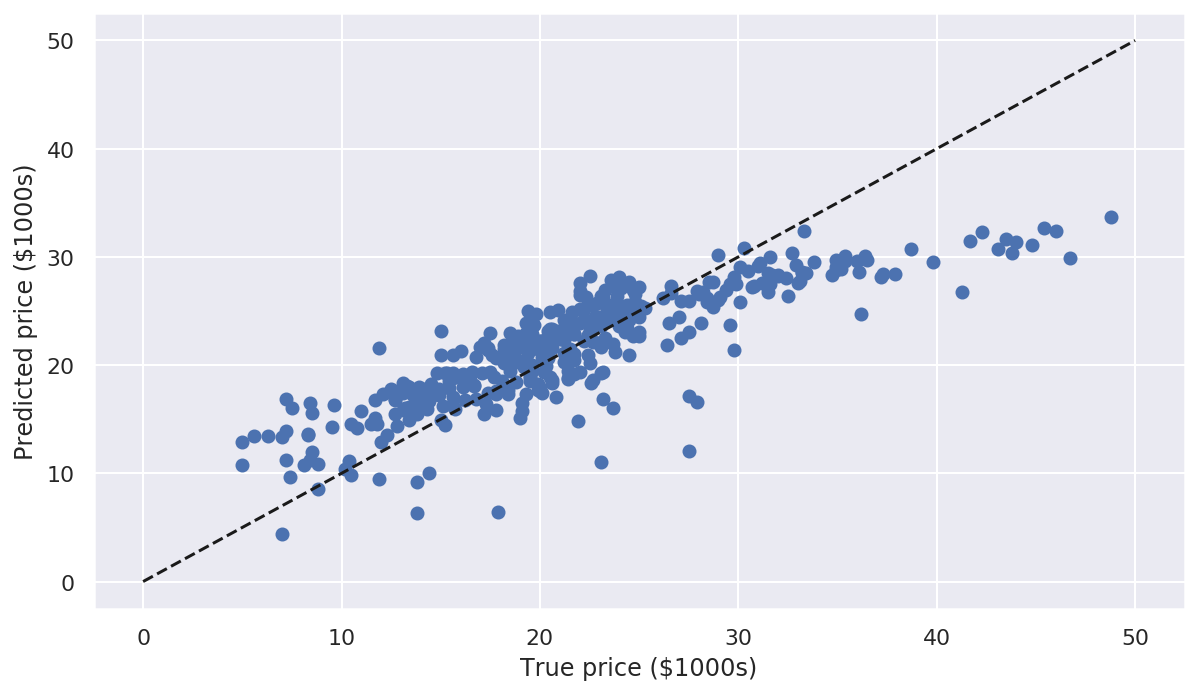

In [42]:
## plt.figure(figsize=(4, 3))
plt.scatter(y_train, y_train_pred_cv)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')
plt.tight_layout()

In [43]:
accuracy =r2_score(y_train, y_train_pred_cv)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.6910345977768511


### Hyperparameters tuning

In [44]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'alpha': [0.0001, 0.001, 0.01, 0.1 ,1, 10],
      'l1_ratio':[.1,.5,.9,1]}
    
]
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(elanet_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=0),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'l1_ratio': [0.1, 0.5, 0.9, 1]}],
             return_train_score=True, scoring='neg_mean_squared_error')

### The best hyperparameter combination found:

In [45]:
grid_search.best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

In [46]:
grid_search.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.1, random_state=0)

### Score of each hyperparameter combination tested during the grid search

In [47]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.8471023449524466 {'alpha': 0.0001, 'l1_ratio': 0.1}
3.8474750221966563 {'alpha': 0.0001, 'l1_ratio': 0.5}
3.8478838284831935 {'alpha': 0.0001, 'l1_ratio': 0.9}
3.8479919859873615 {'alpha': 0.0001, 'l1_ratio': 1}
3.844923846030285 {'alpha': 0.001, 'l1_ratio': 0.1}
3.8451183378207 {'alpha': 0.001, 'l1_ratio': 0.5}
3.846934766802283 {'alpha': 0.001, 'l1_ratio': 0.9}
3.8478018553065905 {'alpha': 0.001, 'l1_ratio': 1}
3.8700796353997506 {'alpha': 0.01, 'l1_ratio': 0.1}
3.8640781969297584 {'alpha': 0.01, 'l1_ratio': 0.5}
3.8525044017372743 {'alpha': 0.01, 'l1_ratio': 0.9}
3.8507591552691065 {'alpha': 0.01, 'l1_ratio': 1}
3.9141651075344734 {'alpha': 0.1, 'l1_ratio': 0.1}
3.9054962052920232 {'alpha': 0.1, 'l1_ratio': 0.5}
3.896175313697137 {'alpha': 0.1, 'l1_ratio': 0.9}
3.894675219951803 {'alpha': 0.1, 'l1_ratio': 1}
4.166182738515158 {'alpha': 1, 'l1_ratio': 0.1}
4.210686576085665 {'alpha': 1, 'l1_ratio': 0.5}
4.320519091230464 {'alpha': 1, 'l1_ratio': 0.9}
4.364926913548522 {'alpha': 1, 

### In a DataFrame

In [48]:
df_cvres=pd.DataFrame(cvres)
df_cvres['mean_test_score_pos_sqrt']=df_cvres['mean_test_score'].apply(lambda x: np.sqrt(-x))
df_cvres['log_param_alpha']=df_cvres['param_alpha'].apply(lambda x: np.log(x))
df_cvres.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,mean_test_score_pos_sqrt,log_param_alpha
0,0.002360,0.000242,0.000653,0.000073,0.0001,0.1,"{'alpha': 0.0001, 'l1_ratio': 0.1}",-7.724733,-15.470735,-14.729138,...,4,-15.094455,-13.209017,-13.312006,-12.774886,-12.640780,-13.406229,0.881179,3.847102,-9.210340
1,0.002054,0.000370,0.000593,0.000117,0.0001,0.5,"{'alpha': 0.0001, 'l1_ratio': 0.5}",-7.730899,-15.469364,-14.726713,...,5,-15.094138,-13.208753,-13.311775,-12.774378,-12.640655,-13.405940,0.881169,3.847475,-9.210340
2,0.001351,0.000209,0.000454,0.000186,0.0001,0.9,"{'alpha': 0.0001, 'l1_ratio': 0.9}",-7.737379,-15.468092,-14.724325,...,7,-15.093978,-13.208618,-13.311657,-12.774126,-12.640587,-13.405793,0.881164,3.847884,-9.210340
3,0.001280,0.000146,0.000366,0.000040,0.0001,1,"{'alpha': 0.0001, 'l1_ratio': 1}",-7.739050,-15.467791,-14.723734,...,8,-15.093964,-13.208606,-13.311646,-12.774105,-12.640580,-13.405780,0.881164,3.847992,-9.210340
4,0.001242,0.000147,0.000376,0.000052,0.001,0.1,"{'alpha': 0.001, 'l1_ratio': 0.1}",-7.643106,-15.517337,-14.785278,...,1,-15.125461,-13.234697,-13.335068,-12.821180,-12.653476,-13.433976,0.882646,3.844924,-6.907755


### Vizualize the grid search results

Text(0, 0.5, 'Avg. mean test score')

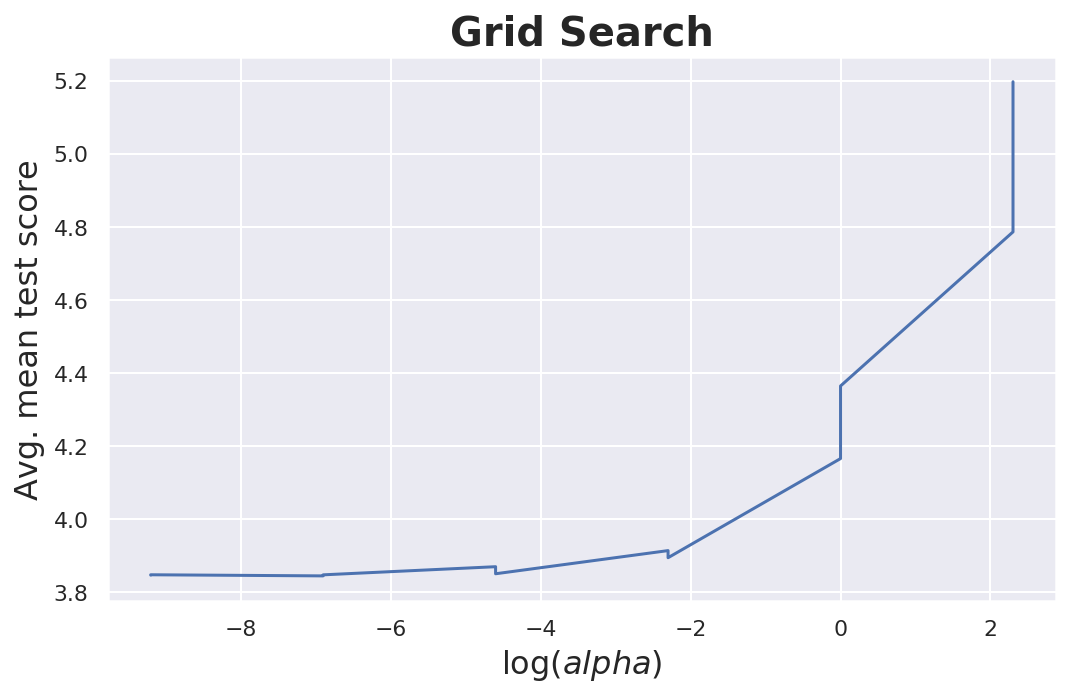

In [49]:
_, ax = plt.subplots(1,1)
plt.plot(df_cvres["log_param_alpha"], df_cvres["mean_test_score_pos_sqrt"])
ax.set_title("Grid Search", fontsize=20, fontweight='bold')
ax.set_xlabel("$\log (alpha)$", fontsize=16)
ax.set_ylabel('Avg. mean test score', fontsize=16)

### Other possibility: for randomized search of hyperparameters

In [50]:
from sklearn.model_selection import RandomizedSearchCV

## What is not covered today:
- more advanced regression algorithms (gradient boosting, random forest)
- classification algorithm
- pipelines